# Neural Network v4 - Ultra-Simple Architecture + Aggressive Regularization
## Overfitting bei sehr wenigen Datensätzen bekämpfen

**Problem in v3:**
- Alle Ensemble-Modelle zeigen >30% Overfitting Gap
- 80 Samples vs. 1,649-3,721 Parameter → Massive Überparametrisierung
- Parameter-to-Sample Ratio von 46.5:1 (sollte <0.1:1 sein!)

**Neue Strategie für v4:**
1. **Radikal vereinfachen**: 15 → 8 → 1 (nur 137 Parameter!)
2. **Aggressive Regularisierung**: 60-70% Dropout, 0.1 Weight Decay
3. **Data Augmentation**: Gaussian Noise um Trainingssamples zu erweitern
4. **Früher stoppen**: Patience 10, Max 100 Epochs
5. **Größere Batches**: 32 statt 16

**Ziel**: Overfitting Gap < 20%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")

Using device: cpu
PyTorch Version: 2.9.1


## 1. Daten laden (wie vorher)

In [2]:
BASE_DIR = Path.cwd().parent
DATA_PATH = BASE_DIR / "housing.csv"

df_full = pd.read_csv(DATA_PATH)
df_full['price_quartile'] = pd.qcut(df_full['median_house_value'], q=4, labels=False)
df_small = df_full.groupby('price_quartile', group_keys=False).apply(
    lambda x: x.sample(n=25, random_state=42)
).drop('price_quartile', axis=1).reset_index(drop=True)

print(f"Datensatz: {len(df_small)} Zeilen")

# Feature Engineering
def engineer_features(df):
    df = df.copy()
    df['households'] = df['households'].replace(0, np.nan)
    df['total_rooms'] = df['total_rooms'].replace(0, np.nan)
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']
    return df

df_small = engineer_features(df_small)
df_small = pd.get_dummies(df_small, columns=['ocean_proximity'], drop_first=False)

X = df_small.drop('median_house_value', axis=1)
y = df_small['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training: {len(X_train)} | Test: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Datensatz: 100 Zeilen
Training: 80 | Test: 20
Features: 15


## 2. Data Augmentation - Gaussian Noise

**Problem**: 80 Samples sind zu wenig für NN

**Lösung**: Erstelle synthetische Samples durch Hinzufügen von Gaussian Noise
- Original: 80 Samples
- Augmented 2x: 160 Samples (Original + 1x Noisy)
- Augmented 3x: 240 Samples (Original + 2x Noisy)

**Noise Level**: 5% der Standardabweichung jedes Features

In [3]:
def augment_data(X, y, noise_level=0.05, augment_factor=2):
    """
    Erstelle augmentierte Daten durch Hinzufügen von Gaussian Noise
    
    Args:
        X: Features (numpy array)
        y: Targets (numpy array)
        noise_level: Noise als Fraction der Std (default: 5%)
        augment_factor: Wie oft augmentieren (2 = Original + 1x Noisy)
    
    Returns:
        X_augmented, y_augmented
    """
    X_list = [X]  # Start mit Original
    y_list = [y]
    
    # Berechne Std für jedes Feature
    feature_std = np.std(X, axis=0)
    
    # Erstelle (augment_factor - 1) noisy Kopien
    for i in range(augment_factor - 1):
        # Noise proportional zur Std jedes Features
        noise = np.random.normal(0, noise_level, X.shape) * feature_std
        X_noisy = X + noise
        X_list.append(X_noisy)
        y_list.append(y)  # Target bleibt gleich
    
    X_augmented = np.vstack(X_list)
    y_augmented = np.hstack(y_list)
    
    return X_augmented, y_augmented

print("Data Augmentation Function bereit!")

Data Augmentation Function bereit!


## 3. Preprocessing - Mit und ohne Augmentation

In [4]:
# Preprocessing
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
y_scaler = StandardScaler()

# Impute und Scale
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# WICHTIG: Scale erst NACH Augmentation!
# Grund: Noise soll proportional zu Original-Scale sein

# Erstelle verschiedene Augmentation-Varianten
augmentation_configs = [
    ("No Aug", 1, 0.0),      # Keine Augmentation
    ("2x Aug", 2, 0.05),     # 2x (Original + 1x Noisy), 5% Noise
    ("3x Aug", 3, 0.05),     # 3x (Original + 2x Noisy), 5% Noise
]

datasets = {}

for name, factor, noise in augmentation_configs:
    if factor == 1:
        # Keine Augmentation
        X_train_aug = X_train_imputed
        y_train_aug = y_train.values
    else:
        # Augmentation VOR Scaling
        X_train_aug, y_train_aug = augment_data(
            X_train_imputed, y_train.values, 
            noise_level=noise, augment_factor=factor
        )
    
    # Jetzt Scale fitting auf augmentierten Daten
    scaler_local = StandardScaler()
    y_scaler_local = StandardScaler()
    
    X_train_scaled = scaler_local.fit_transform(X_train_aug)
    X_test_scaled = scaler_local.transform(X_test_imputed)
    y_train_scaled = y_scaler_local.fit_transform(y_train_aug.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler_local.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Convert to Tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)
    
    datasets[name] = {
        'X_train': X_train_tensor,
        'y_train': y_train_tensor,
        'X_test': X_test_tensor,
        'y_test': y_test_tensor,
        'y_scaler': y_scaler_local,
        'y_train_orig': y_train_aug,
        'y_test_orig': y_test.values,
        'train_size': len(X_train_tensor)
    }
    
    print(f"{name}: Training Samples = {len(X_train_tensor):3d}")

print(f"\nTest Set: {len(X_test)} Samples")
print(f"Features: {X_train_tensor.shape[1]}")

No Aug: Training Samples =  80
2x Aug: Training Samples = 160
3x Aug: Training Samples = 240

Test Set: 20 Samples
Features: 15


## 4. Ultra-Simple Neural Network Architecture

**Minimal NN**: 15 → 8 → 1

**Parameter Count:**
- Layer 1: 15 × 8 + 8 (bias) = 128
- Layer 2: 8 × 1 + 1 (bias) = 9
- **Total: 137 Parameter**

**Vergleich zu v3:**
- v3 Small: 1,649 Parameter (12x mehr!)
- v3 Large: 3,721 Parameter (27x mehr!)

**Parameter-to-Sample Ratio:**
- Ohne Aug: 137 / 80 = 1.71 (immer noch hoch, aber viel besser!)
- Mit 2x Aug: 137 / 160 = 0.86 ✓
- Mit 3x Aug: 137 / 240 = 0.57 ✓✓

In [5]:
class MinimalNet(nn.Module):
    """Ultra-Simple Neural Network für kleine Datensätze"""
    def __init__(self, input_dim=15, hidden_dim=8, dropout_rate=0.6):
        super(MinimalNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Teste Architektur
input_dim = X_train.shape[1]

print("\n" + "="*70)
print("MINIMAL ARCHITECTURE")
print("="*70)

dropout_configs = [0.5, 0.6, 0.7]

for dropout in dropout_configs:
    model = MinimalNet(input_dim, hidden_dim=8, dropout_rate=dropout)
    params = count_parameters(model)
    print(f"\nDropout {dropout*100:.0f}%:")
    print(f"  • Architecture: {input_dim} → 8 → 1")
    print(f"  • Total Parameters: {params}")
    print(f"  • Param/Sample (80): {params/80:.2f}")
    print(f"  • Param/Sample (160): {params/160:.2f}")
    print(f"  • Param/Sample (240): {params/240:.2f}")


MINIMAL ARCHITECTURE

Dropout 50%:
  • Architecture: 15 → 8 → 1
  • Total Parameters: 137
  • Param/Sample (80): 1.71
  • Param/Sample (160): 0.86
  • Param/Sample (240): 0.57

Dropout 60%:
  • Architecture: 15 → 8 → 1
  • Total Parameters: 137
  • Param/Sample (80): 1.71
  • Param/Sample (160): 0.86
  • Param/Sample (240): 0.57

Dropout 70%:
  • Architecture: 15 → 8 → 1
  • Total Parameters: 137
  • Param/Sample (80): 1.71
  • Param/Sample (160): 0.86
  • Param/Sample (240): 0.57


## 5. Early Stopping (aggressiver als v3)

In [6]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose and self.counter % 3 == 0:
                print(f"    Early Stopping Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n    ⚠️  Early Stopping bei Epoch {epoch}!")
                    print(f"    Bester Val Loss: {self.best_loss:.4f} (Epoch {self.best_epoch})")
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0

def train_minimal_model(
    model, X_train, y_train, X_test, y_test,
    max_epochs=100, batch_size=32, lr=0.001, weight_decay=0.1, patience=10
):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    for epoch in range(max_epochs):
        model.train()
        train_losses = []
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test).squeeze()
            val_loss = criterion(val_outputs, y_test).item()
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(current_lr)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{max_epochs}] - Train: {avg_train_loss:.4f}, Val: {val_loss:.4f}, LR: {current_lr:.6f}")
        
        early_stopping(val_loss, epoch + 1)
        if early_stopping.early_stop:
            break
    
    final_epoch = epoch + 1
    print(f"\n✓ Training beendet nach {final_epoch} Epochen")
    return history, final_epoch

print("Training-Funktion bereit!")

Training-Funktion bereit!


## 6. Trainiere alle Modell-Varianten

**Test-Matrix:**
- 3 Data Augmentation Levels: None, 2x, 3x
- 3 Dropout Rates: 50%, 60%, 70%
- **Total: 9 Modelle**

In [7]:
MAX_EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.1  # 10x höher als v3!
PATIENCE = 10       # Halb so viel wie v3!

augmentation_names = ["No Aug", "2x Aug", "3x Aug"]
dropout_rates = [0.5, 0.6, 0.7]

results_all = []
trained_models = {}
histories = {}

print("="*80)
print("TRAINING: 9 MODELL-VARIANTEN")
print("="*80)
print(f"Hyperparameters: Max Epochs={MAX_EPOCHS}, Batch Size={BATCH_SIZE}, LR={LEARNING_RATE}")
print(f"Regularization: Weight Decay={WEIGHT_DECAY} (10x höher!), Patience={PATIENCE} (50% weniger!)")
print("="*80 + "\n")

for aug_name in augmentation_names:
    dataset = datasets[aug_name]
    
    for dropout in dropout_rates:
        model_name = f"{aug_name} - Dropout {int(dropout*100)}%"
        
        print(f"\n{'='*70}")
        print(f"TRAINING: {model_name}")
        print(f"Training Samples: {dataset['train_size']}")
        print(f"{'='*70}")
        
        model = MinimalNet(input_dim, hidden_dim=8, dropout_rate=dropout).to(device)
        
        history, final_epoch = train_minimal_model(
            model, 
            dataset['X_train'], dataset['y_train'],
            dataset['X_test'], dataset['y_test'],
            MAX_EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, PATIENCE
        )
        
        trained_models[model_name] = model
        histories[model_name] = history
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            y_train_pred_scaled = model(dataset['X_train']).squeeze().cpu().numpy()
            y_test_pred_scaled = model(dataset['X_test']).squeeze().cpu().numpy()
        
        y_train_pred = dataset['y_scaler'].inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
        y_test_pred = dataset['y_scaler'].inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
        
        # Metrics auf ORIGINALEN Training-Daten (nicht augmentierten)
        # Für faire Vergleiche mit v3
        if aug_name == "No Aug":
            train_rmse = np.sqrt(mean_squared_error(dataset['y_train_orig'], y_train_pred))
            train_r2 = r2_score(dataset['y_train_orig'], y_train_pred)
        else:
            # Bei Augmentation: Nur die ersten 80 Original-Samples verwenden
            y_train_orig_only = dataset['y_train_orig'][:80]
            y_train_pred_only = y_train_pred[:80]
            train_rmse = np.sqrt(mean_squared_error(y_train_orig_only, y_train_pred_only))
            train_r2 = r2_score(y_train_orig_only, y_train_pred_only)
        
        test_rmse = np.sqrt(mean_squared_error(dataset['y_test_orig'], y_test_pred))
        test_r2 = r2_score(dataset['y_test_orig'], y_test_pred)
        
        rmse_gap = test_rmse - train_rmse
        rmse_gap_percent = (rmse_gap / train_rmse) * 100
        
        results_all.append({
            'Model': model_name,
            'Augmentation': aug_name,
            'Dropout': f"{int(dropout*100)}%",
            'Train Size': dataset['train_size'],
            'Epochs': final_epoch,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'RMSE Gap': rmse_gap,
            'Gap %': rmse_gap_percent,
            'Train R²': train_r2,
            'Test R²': test_r2
        })

print("\n" + "="*80)
print("ALLE MODELLE TRAINIERT!")
print("="*80)

TRAINING: 9 MODELL-VARIANTEN
Hyperparameters: Max Epochs=100, Batch Size=32, LR=0.001
Regularization: Weight Decay=0.1 (10x höher!), Patience=10 (50% weniger!)


TRAINING: No Aug - Dropout 50%
Training Samples: 80
Epoch [20/100] - Train: 1.0279, Val: 1.0666, LR: 0.001000
Epoch [40/100] - Train: 0.8293, Val: 0.9021, LR: 0.001000
Epoch [60/100] - Train: 0.7612, Val: 0.7764, LR: 0.001000
Epoch [80/100] - Train: 0.5992, Val: 0.6815, LR: 0.001000
Epoch [100/100] - Train: 0.6147, Val: 0.6188, LR: 0.001000

✓ Training beendet nach 100 Epochen

TRAINING: No Aug - Dropout 60%
Training Samples: 80
Epoch [20/100] - Train: 1.0194, Val: 0.8792, LR: 0.001000
Epoch [40/100] - Train: 0.6574, Val: 0.7974, LR: 0.001000
Epoch [60/100] - Train: 0.7733, Val: 0.7386, LR: 0.001000
Epoch [80/100] - Train: 0.6699, Val: 0.6863, LR: 0.001000
Epoch [100/100] - Train: 0.5544, Val: 0.6257, LR: 0.001000

✓ Training beendet nach 100 Epochen

TRAINING: No Aug - Dropout 70%
Training Samples: 80
Epoch [20/100] - Train: 

## 7. Performance-Analyse - Alle Modelle

In [8]:
results_df = pd.DataFrame(results_all)

print("\n" + "="*120)
print("PERFORMANCE: ALLE v4 MODELLE")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

# Beste Modelle
best_gap = results_df.loc[results_df['Gap %'].idxmin()]
best_test = results_df.loc[results_df['Test RMSE'].idxmin()]

print("\n" + "="*80)
print("BESTE MODELLE")
print("="*80)
print(f"\nBester Overfitting Gap:")
print(f"  • {best_gap['Model']}")
print(f"  • Gap: {best_gap['Gap %']:.1f}%")
print(f"  • Test RMSE: ${best_gap['Test RMSE']:,.2f}")

print(f"\nBester Test RMSE:")
print(f"  • {best_test['Model']}")
print(f"  • Test RMSE: ${best_test['Test RMSE']:,.2f}")
print(f"  • Gap: {best_test['Gap %']:.1f}%")
print("="*80)


PERFORMANCE: ALLE v4 MODELLE
               Model Augmentation Dropout  Train Size  Epochs   Train RMSE    Test RMSE    RMSE Gap     Gap %  Train R²  Test R²
No Aug - Dropout 50%       No Aug     50%          80     100 82439.981983 88660.021049 6220.039066  7.544930  0.465017 0.413322
No Aug - Dropout 60%       No Aug     60%          80     100 84341.717597 89155.120416 4813.402819  5.707025  0.440050 0.406751
No Aug - Dropout 70%       No Aug     70%          80     100 87740.881463 90186.300022 2445.418559  2.787091  0.394006 0.392948
2x Aug - Dropout 50%       2x Aug     50%         160     100 68970.086461 78159.930757 9189.844296 13.324391  0.625557 0.544055
2x Aug - Dropout 60%       2x Aug     60%         160     100 82075.628607 85034.019580 2958.390973  3.604469  0.469735 0.460328
2x Aug - Dropout 70%       2x Aug     70%         160     100 80664.959691 86881.423766 6216.464074  7.706523  0.487806 0.436624
3x Aug - Dropout 50%       3x Aug     50%         240      72 69273

## 11. SCATTER PLOT: Predictions vs Actual
### Prüfe ob v4 einen Ceiling Effect hat!

SCATTER PLOT: 3x Aug - Dropout 50%
Test RMSE: $76,049.31
Test R²: 0.568
Gap: 9.8%

📊 METRIKEN:
  RMSE: $76,049.31
  MAE: $56,816.41
  R²: 0.568
  Samples: 20


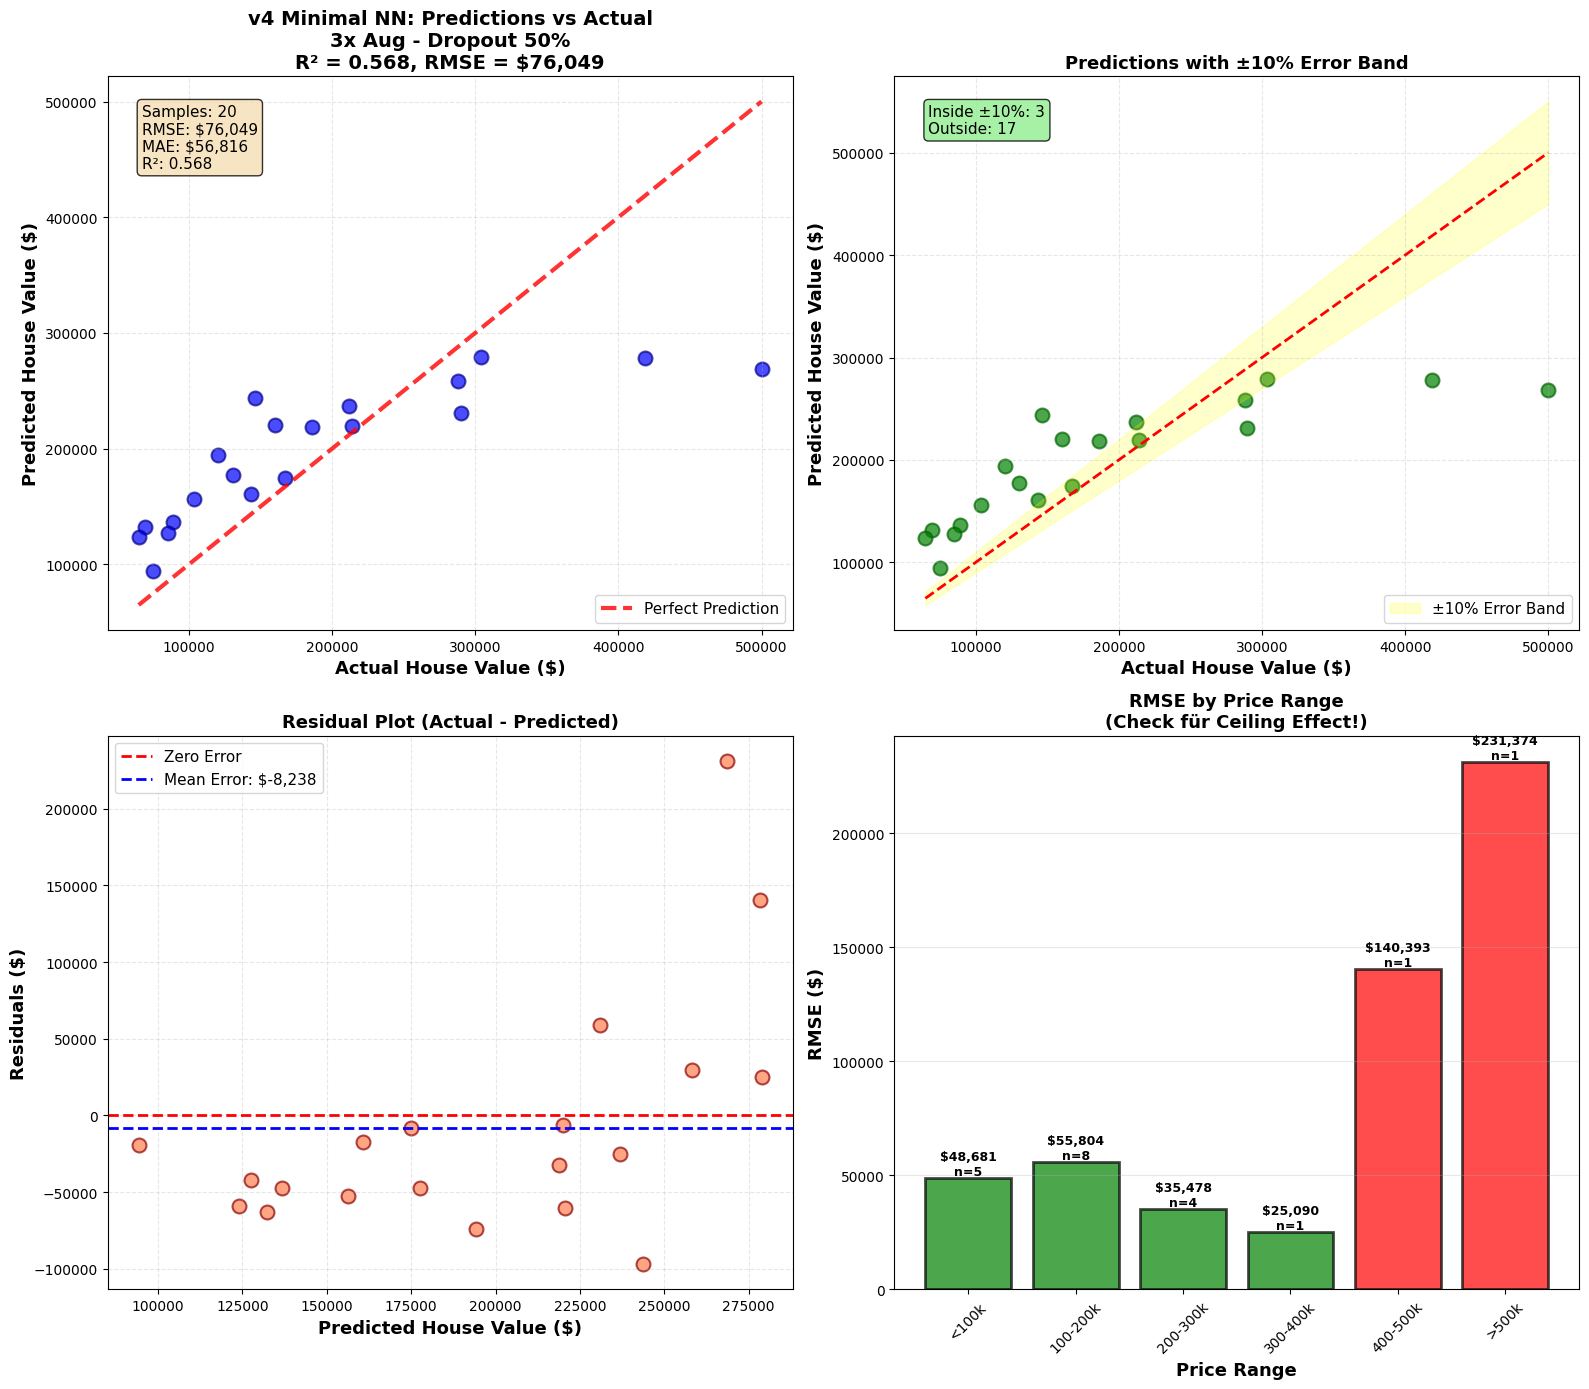


CEILING EFFECT CHECK:
Max Actual Price: $500,001
Max Predicted Price: $278,810
Min Actual Price: $64,900
Min Predicted Price: $94,236

⚠️  CEILING EFFECT DETECTED!
   Model sagt maximal $278,810 vorher, aber es gibt Häuser bis $500,001


In [9]:
# Nehme das BESTE Modell (nach Test RMSE)
best_model_name = results_df.loc[results_df['Test RMSE'].idxmin(), 'Model']
best_model_aug = results_df.loc[results_df['Test RMSE'].idxmin(), 'Augmentation']

print("="*80)
print(f"SCATTER PLOT: {best_model_name}")
print("="*80)
print(f"Test RMSE: ${results_df.loc[results_df['Test RMSE'].idxmin(), 'Test RMSE']:,.2f}")
print(f"Test R²: {results_df.loc[results_df['Test RMSE'].idxmin(), 'Test R²']:.3f}")
print(f"Gap: {results_df.loc[results_df['Test RMSE'].idxmin(), 'Gap %']:.1f}%")
print("="*80)

# Hole das beste Modell und Dataset
best_model = trained_models[best_model_name]
best_dataset = datasets[best_model_aug]

# Predictions
best_model.eval()
with torch.no_grad():
    y_test_pred_scaled = best_model(best_dataset['X_test']).squeeze().cpu().numpy()

# Zurück zur Original-Skala
y_test_pred = best_dataset['y_scaler'].inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = best_dataset['y_test_orig']

# RMSE und R²
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mae = mean_absolute_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print(f"\n📊 METRIKEN:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE: ${mae:,.2f}")
print(f"  R²: {r2:.3f}")
print(f"  Samples: {len(y_test_actual)}")

# SCATTER PLOTS
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ============================================
# PLOT 1: Predictions vs Actual (Haupt-Plot)
# ============================================
ax = axes[0, 0]
ax.scatter(y_test_actual, y_test_pred, alpha=0.7, s=100, 
           c='blue', edgecolors='darkblue', linewidth=1.5)

# Perfect Prediction Line
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 
        'r--', lw=3, label='Perfect Prediction', alpha=0.8)

ax.set_xlabel('Actual House Value ($)', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted House Value ($)', fontsize=13, fontweight='bold')
ax.set_title(f'v4 Minimal NN: Predictions vs Actual\n{best_model_name}\nR² = {r2:.3f}, RMSE = ${rmse:,.0f}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.ticklabel_format(style='plain', axis='both')

# Textbox mit Statistiken
textstr = f'Samples: {len(y_test_actual)}\nRMSE: ${rmse:,.0f}\nMAE: ${mae:,.0f}\nR²: {r2:.3f}'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================
# PLOT 2: Mit ±10% Fehlerband
# ============================================
ax = axes[0, 1]
ax.scatter(y_test_actual, y_test_pred, alpha=0.7, s=100,
           c='green', edgecolors='darkgreen', linewidth=1.5)
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# 10% Fehlerbereich
error_margin = 0.1
sorted_actual = sorted(y_test_actual)
sorted_upper = [x * (1 + error_margin) for x in sorted_actual]
sorted_lower = [x * (1 - error_margin) for x in sorted_actual]

ax.fill_between(sorted_actual, sorted_lower, sorted_upper, 
                 alpha=0.2, color='yellow', label='±10% Error Band')

ax.set_xlabel('Actual House Value ($)', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted House Value ($)', fontsize=13, fontweight='bold')
ax.set_title('Predictions with ±10% Error Band', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.ticklabel_format(style='plain', axis='both')

# Zähle Punkte außerhalb des Bandes
within_band = np.sum(np.abs(y_test_pred - y_test_actual) / y_test_actual <= 0.1)
outside_band = len(y_test_actual) - within_band
ax.text(0.05, 0.95, f'Inside ±10%: {within_band}\nOutside: {outside_band}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# ============================================
# PLOT 3: Residual Plot
# ============================================
ax = axes[1, 0]
residuals = y_test_actual - y_test_pred

ax.scatter(y_test_pred, residuals, alpha=0.7, s=100,
           c='coral', edgecolors='darkred', linewidth=1.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.axhline(y=np.mean(residuals), color='blue', linestyle='--', linewidth=2,
           label=f'Mean Error: ${np.mean(residuals):,.0f}')

ax.set_xlabel('Predicted House Value ($)', fontsize=13, fontweight='bold')
ax.set_ylabel('Residuals ($)', fontsize=13, fontweight='bold')
ax.set_title('Residual Plot (Actual - Predicted)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.ticklabel_format(style='plain', axis='both')

# ============================================
# PLOT 4: Price Range Analyse
# ============================================
ax = axes[1, 1]

# Gruppiere in Preisbereiche
price_bins = [0, 100000, 200000, 300000, 400000, 500000, 1000000]
price_labels = ['<100k', '100-200k', '200-300k', '300-400k', '400-500k', '>500k']
y_test_binned = pd.cut(y_test_actual, bins=price_bins, labels=price_labels)

# Berechne RMSE pro Preisbereich
rmse_per_bin = []
count_per_bin = []
for label in price_labels:
    mask = y_test_binned == label
    if mask.sum() > 0:
        rmse_bin = np.sqrt(mean_squared_error(y_test_actual[mask], y_test_pred[mask]))
        rmse_per_bin.append(rmse_bin)
        count_per_bin.append(mask.sum())
    else:
        rmse_per_bin.append(0)
        count_per_bin.append(0)

# Plot
colors = ['green' if rmse < 80000 else 'orange' if rmse < 100000 else 'red' 
          for rmse in rmse_per_bin]
bars = ax.bar(range(len(price_labels)), rmse_per_bin, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

ax.set_xticks(range(len(price_labels)))
ax.set_xticklabels(price_labels, rotation=45)
ax.set_ylabel('RMSE ($)', fontsize=13, fontweight='bold')
ax.set_xlabel('Price Range', fontsize=13, fontweight='bold')
ax.set_title('RMSE by Price Range\n(Check für Ceiling Effect!)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.ticklabel_format(style='plain', axis='y')

# Annotate mit Counts und RMSE
for i, (bar, count, rmse_val) in enumerate(zip(bars, count_per_bin, rmse_per_bin)):
    if count > 0:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${rmse_val:,.0f}\nn={count}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('v4_scatter_plot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("CEILING EFFECT CHECK:")
print("="*80)
print(f"Max Actual Price: ${y_test_actual.max():,.0f}")
print(f"Max Predicted Price: ${y_test_pred.max():,.0f}")
print(f"Min Actual Price: ${y_test_actual.min():,.0f}")
print(f"Min Predicted Price: ${y_test_pred.min():,.0f}")

if y_test_pred.max() < y_test_actual.max() * 0.8:
    print("\n⚠️  CEILING EFFECT DETECTED!")
    print(f"   Model sagt maximal ${y_test_pred.max():,.0f} vorher, aber es gibt Häuser bis ${y_test_actual.max():,.0f}")
else:
    print("\n✅ KEIN starker Ceiling Effect!")
    print(f"   Model kann hohe Preise bis ${y_test_pred.max():,.0f} vorhersagen")

print("="*80)